## Install Fenics

In [ ]:
# Add FEniCS PPA to Ubuntu and install (Python3.6)
!echo deb http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic main >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 2C5275D7EF63D9DE2D28D3702940F5212B746472
!apt-get -qq update

!apt-get -y install fenics > /dev/null

# Reinstall dolfin for Python3.7
!rm -r /usr/lib/petsc/lib/python3/dist-packages/dolfin
!git clone https://bitbucket.org/fenics-project/dolfin
!cd dolfin/python && python3 setup.py install

# Reinstall mpi4py for Python3.7
!rm -r /usr/lib/python3/dist-packages/mpi4py*
!pip3 install mpi4py --upgrade

Executing: /tmp/apt-key-gpghome.b3Rg4h1US0/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 2C5275D7EF63D9DE2D28D3702940F5212B746472
gpg: key 2940F5212B746472: public key "Launchpad PPA for FEniCS Packages Team" imported
gpg: Total number processed: 1
gpg:               imported: 1
Extracting templates from packages: 100%
Cloning into 'dolfin'...
Receiving objects: 100% (239592/239592), 50.05 MiB | 19.30 MiB/s, done.
Resolving deltas: 100% (183484/183484), done.
running install
running bdist_egg
running egg_info
creating fenics_dolfin.egg-info
writing fenics_dolfin.egg-info/PKG-INFO
writing dependency_links to fenics_dolfin.egg-info/dependency_links.txt
writing requirements to fenics_dolfin.egg-info/requires.txt
writing top-level names to fenics_dolfin.egg-info/top_level.txt
writing manifest file 'fenics_dolfin.egg-info/SOURCES.txt'
writing manifest file 'fenics_dolfin.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_p

## Allen-Cahn Equation

Allen-Cahn equation is shown below.

$$
\begin{equation}
\begin{aligned}
c_{t}-\Delta c+\frac{1}{\varepsilon^{2}} f(c)&=0, \quad(x, t) \in \Omega \times(0, T] \\
\left.\partial_{n} c\right|_{\partial \Omega}&=0 \\
\left.c\right|_{t=0}&=c_{0}
\end{aligned}
\end{equation}
$$

### Weak Form
$$
\begin{equation}
\begin{aligned}
\int_{\Omega}c_{t}vdx + \int_{\Omega}\nabla c \cdot\nabla v dx+\int_{\Omega}\frac{1}{\varepsilon^{2}} f(c)vdx&=0, \quad v \in V
\end{aligned}
\end{equation}
$$
where
$$
\begin{equation}
\begin{aligned}
f(c) = c^3 - c
\end{aligned}
\end{equation}
$$

$$
c_0 = 0.1cos(2\pi x)sin(2\pi x)\\
\varepsilon = 0.01 \\
dt = 0.001 \\
$$

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 29 22:12:33 2020

added term C:outer(grad(c),grad(c))
@author: bilginkocak
"""
from dolfin import *
import numpy as np
import random
import time
start_time = time.time()
mesh = RectangleMesh(Point(-1, -1), Point(1,1),96,96)
V = FunctionSpace(mesh, "Lagrange",1)

parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"
#parameters["form_compiler"]["quadrature_degree"] = 5

c = Function(V)
c0 = Function(V)
v = TestFunction(V)

dt = 0.001
tend = 10
num = int(tend/dt) + 1
time_array = np.linspace(0,tend, num)
epsilon = Constant(0.1)


# Class representing the intial conditions
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):    
        values[0] = (random.uniform(0, 1))
# Create intial conditions and interpolate
u_init = InitialConditions(degree=1)
c.interpolate(u_init)
c0.interpolate(u_init)

initial_c = Expression(('sinh(sqrt(2/eps)*x[0])/(sqrt(2+ sinh(sqrt(2/eps)*x[0])*sinh(sqrt(2/eps)*x[0])))'),eps=epsilon,degree=2)

# initial_c = Expression(('0.1*cos(2*pi*x[0])*cos(2*pi*x[1])'),pi=np.pi,degree=2)
initial_c = Expression(('0.1*cos(2*pi*x[0])*cos(2*pi*x[1])'),pi=np.pi,degree=2)
c0 = interpolate(initial_c,V)
c.interpolate(initial_c)

f = c**3 - c

F = (c-c0)*v*dx + (epsilon**2)*dt*dot(grad(c), grad(v))*dx + dt*f*v*dx

file_results = XDMFFile("./allen-cahn/allen_cahn.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

c.rename("c", "concentration")

def save_to_file(c, t):
    c.rename("c", "concentration")
    file_results.write(c, t)

count = 0
for t in time_array:
    if t <= 0.01:
      save_to_file(c, t)
    elif t<=10:
      if count % 100 == 0:
        save_to_file(c, t)
    else:
      if count % 100 == 0:
        save_to_file(c, t)
    solve(F==0, c ,solver_parameters={"newton_solver":{"linear_solver":"lu",
                                                        #"relative_tolerance": 1e-6,
                                                        #"preconditioner":"ilu",
                                                        #"convergence_criterion":"incremental",
                                                        }})

    count += 1
    print(f"time = {t}")
    c0.assign(c)

save_to_file(c, t)

elapsed_time = time.time() - start_time
print("Elapsed time : " + str(elapsed_time))

Görüntülenen çıkış son 5000 satıra kısaltıldı.
time = 5.002
time = 5.003
time = 5.0040000000000004
time = 5.005
time = 5.006
time = 5.007
time = 5.008
time = 5.009
time = 5.01
time = 5.011
time = 5.0120000000000005
time = 5.013
time = 5.014
time = 5.015
time = 5.016
time = 5.017
time = 5.018
time = 5.019
time = 5.0200000000000005
time = 5.021
time = 5.022
time = 5.023
time = 5.024
time = 5.025
time = 5.026
time = 5.027
time = 5.0280000000000005
time = 5.029
time = 5.03
time = 5.031
time = 5.032
time = 5.033
time = 5.034
time = 5.035
time = 5.0360000000000005
time = 5.037
time = 5.038
time = 5.039
time = 5.04
time = 5.041
time = 5.042
time = 5.043
time = 5.0440000000000005
time = 5.045
time = 5.046
time = 5.047
time = 5.048
time = 5.049
time = 5.05
time = 5.051
time = 5.0520000000000005
time = 5.053
time = 5.054
time = 5.055
time = 5.056
time = 5.057
time = 5.058
time = 5.059
time = 5.0600000000000005
time = 5.061
time = 5.062
time = 5.063
time = 5.064
time = 5.065
time = 5.066
time = 5

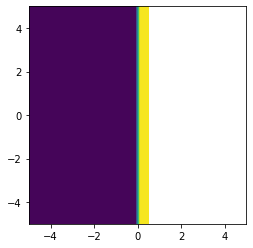

In [ ]:
initial_c = Expression(('sinh(sqrt(2/eps)*x[0])/(sqrt(2+ sinh(sqrt(2/eps)*x[0])*sinh(sqrt(2/eps)*x[0])))'),eps=epsilon,degree=2)
c0 = interpolate(initial_c,V)
plot(c0)
